In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Loading the dataset
data = pd.read_csv('/content/Data Analyst _ Sample Data _HDM - call-data-udpated.csv')


In [3]:
data.head()

,Call Id,Lead Id,Campaign ID,Advertiser Id,Hid,Call Status,Lead Status,Agent Duration(seconds),Customer Duration(seconds),From Calling Number,To Calling Number,Attempt No,Created At,Updated At,Agent Id,Agent Name
0,26807,410987,930228,1883,40831aceu6850re1ece43deeqf20a6o,no-answer,Not Interested,8,0,9.186570e+11,+919552777764,1,2024-04-01 11:35:19,2024-04-01 11:35:27,2728,Mansi Jaiswal
1,26808,410986,930228,1883,3dc489fbg6850pe1ece43deewf20a6v,completed,Not Interested,51,34,9.186570e+11,+917275507242,1,2024-04-01 11:35:27,2024-04-01 11:36:19,2728,Mansi Jaiswal
2,26809,410985,930228,1883,92d7bfbag6850se1ece43deevf20a6y,no-answer,Invalid Number,9,0,9.186570e+11,+919430734094,1,2024-04-01 11:36:19,2024-04-01 11:36:28,2728,Mansi Jaiswal
3,26810,410984,930228,1883,3a9872eem6850oe1ece43deetf20a6m,completed,Not Interested,45,25,9.186570e+11,+918349289209,1,2024-04-01 11:36:29,2024-04-01 11:37:15,2728,Mansi Jaiswal
4,26811,410981,930228,1883,3dde873bx6850je1ece43deehf20a6u,no-answer,Busy,45,0,9.186570e+11,+917054670061,1,2024-04-01 11:37:14,2024-04-01 11:38:00,2728,Mansi Jaiswal


Data Cleaning

In [2]:
# Convert date columns to datetime
data['Created At'] = pd.to_datetime(data['Created At'])
data['Updated At'] = pd.to_datetime(data['Updated At'])

# Convert duration columns to numeric
data['Agent Duration(seconds)'] = pd.to_numeric(data['Agent Duration(seconds)'], errors='coerce')
data['Customer Duration(seconds)'] = pd.to_numeric(data['Customer Duration(seconds)'], errors='coerce')

# Handle missing values if necessary
data.fillna(0, inplace=True)


**EDA**

In [4]:
# Drop the 'From Calling Number' column
data.drop(columns=['From Calling Number'], inplace=True) # not necessary

Summary statistics

In [5]:
# Display the first few rows of the dataset
print(data.head())

# Summary statistics for numeric columns
print(data.describe())

# Information about the dataset
print(data.info())

# Check for missing values
print(data.isnull().sum())


   Call Id  Lead Id  Campaign ID  Advertiser Id  \
0    26807   410987       930228           1883   
1    26808   410986       930228           1883   
2    26809   410985       930228           1883   
3    26810   410984       930228           1883   
4    26811   410981       930228           1883   

                               Hid Call Status     Lead Status  \
0  40831aceu6850re1ece43deeqf20a6o   no-answer  Not Interested   
1  3dc489fbg6850pe1ece43deewf20a6v   completed  Not Interested   
2  92d7bfbag6850se1ece43deevf20a6y   no-answer  Invalid Number   
3  3a9872eem6850oe1ece43deetf20a6m   completed  Not Interested   
4  3dde873bx6850je1ece43deehf20a6u   no-answer            Busy   

   Agent Duration(seconds)  Customer Duration(seconds) To Calling Number  \
0                        8                           0     +919552777764   
1                       51                          34     +917275507242   
2                        9                           0     +91943073

Analyzing the distribution of calls

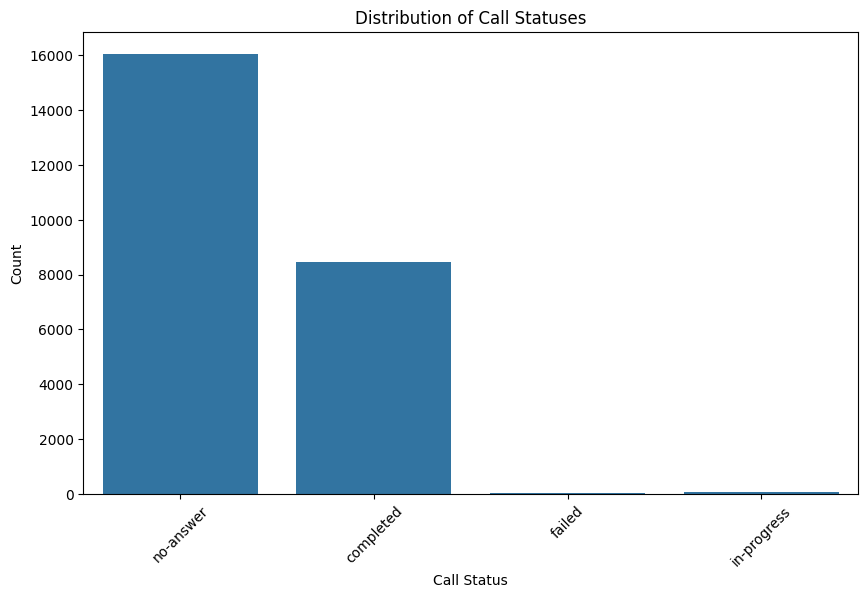

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Call Status')
plt.title('Distribution of Call Statuses')
plt.xlabel('Call Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [7]:
call_status_distribution = data['Call Status'].value_counts().reset_index()
call_status_distribution.columns = ['Call Status', 'Count']
print(call_status_distribution
)

   Call Status  Count
0    no-answer  16042
1    completed   8454
2  in-progress     85
3       failed     42


Distribution of lead status

               Lead Status  Count
0                No Answer   6478
1           Not Interested   4916
2                     Busy   3743
3               Interested   3451
4            Not Reachable   1443
5              Voice Issue   1208
6           Invalid Number    785
7         Language Barrier    657
8   Bought Another Product    479
9                Call Back    452
10          Already Bought    340
11        Already Verified    240
12                 Opt Out    107
13     Already Buy/ Bought     87
14                  Failed     81
15     Out of Geo Location     58
16   Not Eligible - Income     53
17      Not Eligible - Age     16
18                 Hung-up     10
19               Duplicate      9
20                Status26      9
21                 Ringing      1


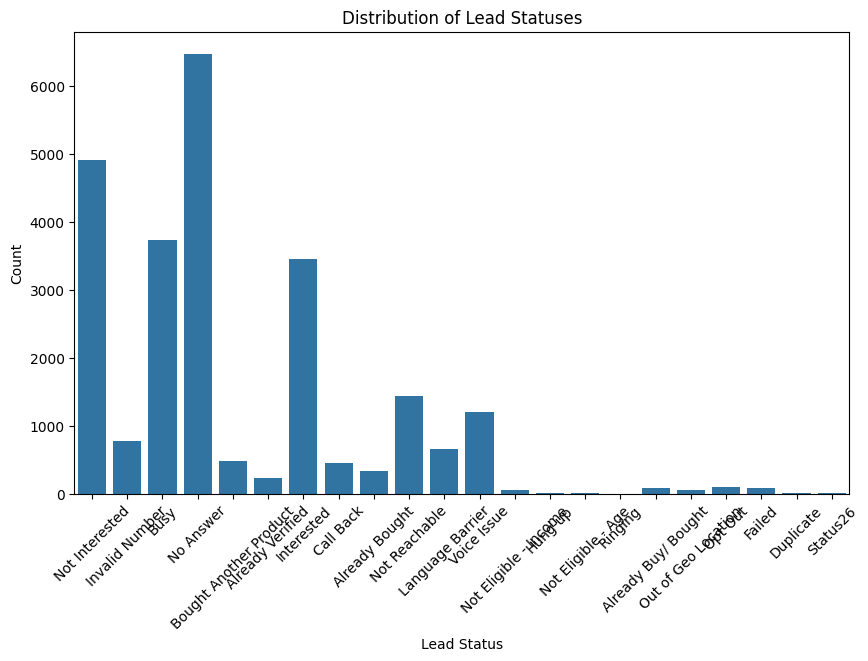

In [8]:
lead_status_distribution = data['Lead Status'].value_counts().reset_index()
lead_status_distribution.columns = ['Lead Status', 'Count']
print(lead_status_distribution)
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Lead Status')
plt.title('Distribution of Lead Statuses')
plt.xlabel('Lead Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Distribution of callls duration

count    24623.000000
mean        35.938432
std         26.882256
min          0.000000
25%         17.000000
50%         33.000000
75%         48.000000
max        495.000000
Name: Agent Duration(seconds), dtype: float64
count    24623.000000
mean        12.986679
std         25.441664
min          0.000000
25%          0.000000
50%          0.000000
75%         18.000000
max        476.000000
Name: Customer Duration(seconds), dtype: float64


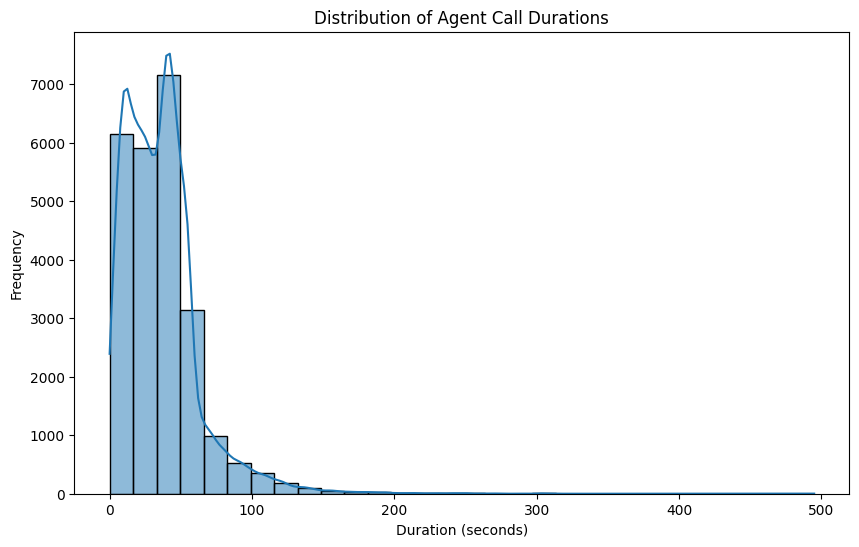

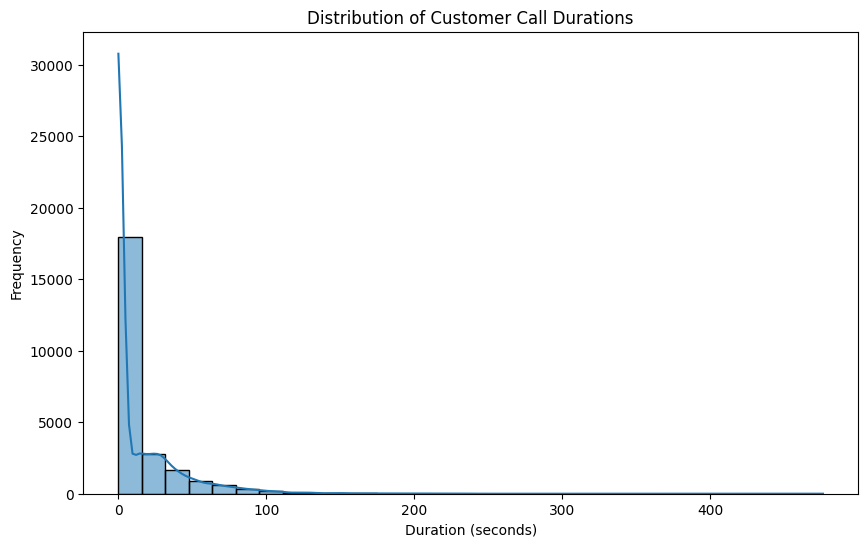

In [9]:
agent_duration_summary = data['Agent Duration(seconds)'].describe()
customer_duration_summary = data['Customer Duration(seconds)'].describe()
print(agent_duration_summary)
print(customer_duration_summary)
plt.figure(figsize=(10, 6))
sns.histplot(data['Agent Duration(seconds)'], kde=True, bins=30)
plt.title('Distribution of Agent Call Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['Customer Duration(seconds)'], kde=True, bins=30)
plt.title('Distribution of Customer Call Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


Calls Over Time

          Date  Number of Calls
0   2024-04-01              406
1   2024-04-02              388
2   2024-04-03              397
3   2024-04-04              421
4   2024-04-05              460
5   2024-04-06              692
6   2024-04-08              671
7   2024-04-09              839
8   2024-04-10              837
9   2024-04-13               56
10  2024-04-15              537
11  2024-04-16              746
12  2024-04-17              437
13  2024-04-18              588
14  2024-04-19              236
15  2024-04-20              205
16  2024-04-21               13
17  2024-04-22              181
18  2024-04-23              159
19  2024-04-24               79
20  2024-04-25               31
21  2024-04-26                6
22  2024-04-27                1
23  2024-04-29                1
24  2024-04-30                2
25  2024-05-01                3
26  2024-05-02               21
27  2024-05-03               32
28  2024-05-04               25
29  2024-05-05                3
30  2024

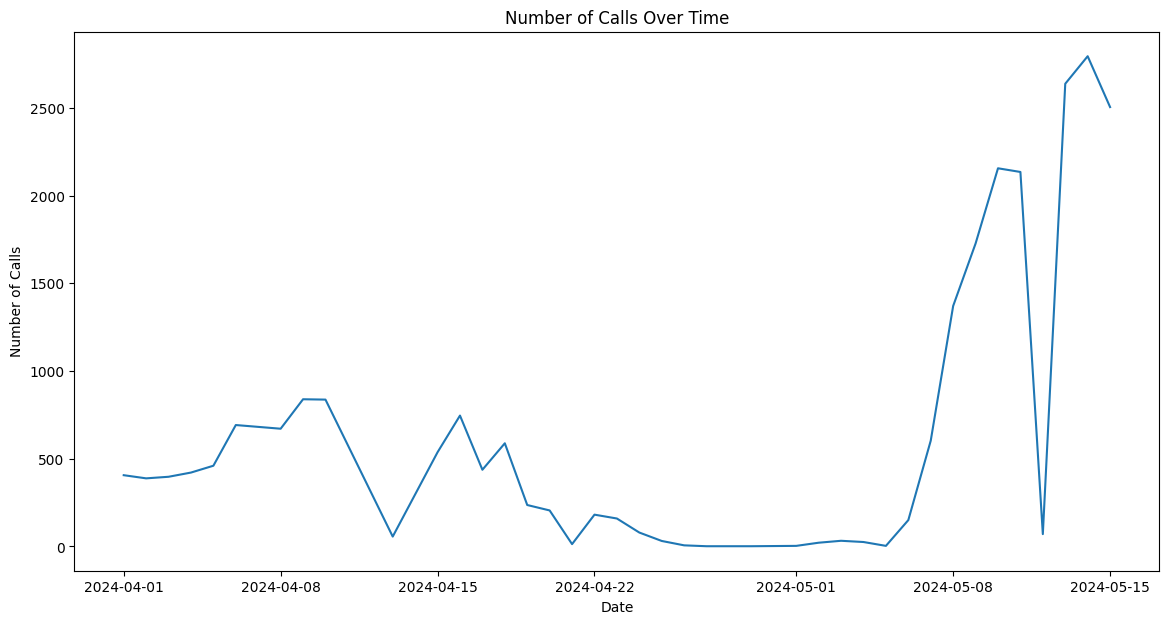

In [10]:
calls_over_time = data.groupby(data['Created At'].dt.date).size().reset_index(name='Number of Calls')
calls_over_time.columns = ['Date', 'Number of Calls']
print(calls_over_time)
plt.figure(figsize=(14, 7))
data['Created At'].groupby(data['Created At'].dt.date).count().plot(kind='line')
plt.title('Number of Calls Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.show()


Call status by campaign

Call Status  completed  failed  in-progress  no-answer
Campaign ID                                           
930056               0       0            0          2
930126              11       0            0         34
930171               5       0            0         27
930228            2088       8           48       3549
930247             381       0            0        722
930248             533       0            0        965
930251               7       0            0         13
930259               3       0            0         38
930260               9       0            0         46
930261               4       0            0         23
930263             677       6            5       1266
930264             682       4            5       1443
930265             304       2            3        640
930266             696       7            5       1396
930267             376       3            1        775
930268             717       3            5       1134
930269    

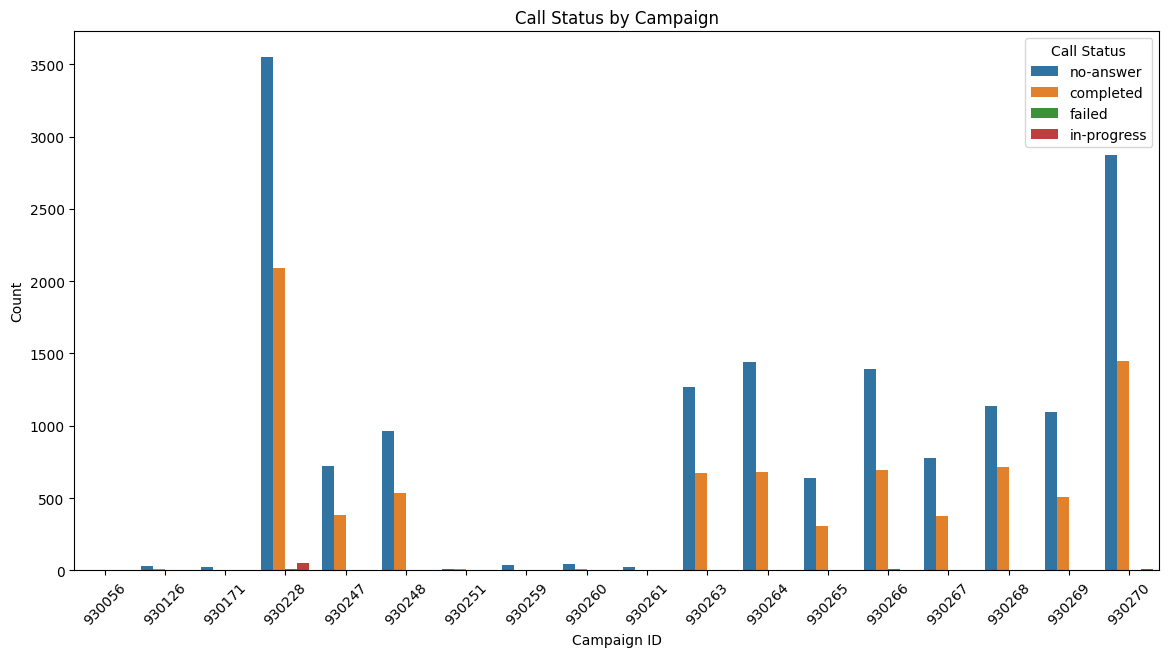

In [11]:
call_status_by_campaign = pd.crosstab(data['Campaign ID'], data['Call Status'])
print(call_status_by_campaign)

plt.figure(figsize=(14, 7))
sns.countplot(data=data, x='Campaign ID', hue='Call Status')
plt.title('Call Status by Campaign')
plt.xlabel('Campaign ID')
plt.ylabel('Count')
plt.legend(title='Call Status')
plt.xticks(rotation=45)
plt.show()


lead status by campaign

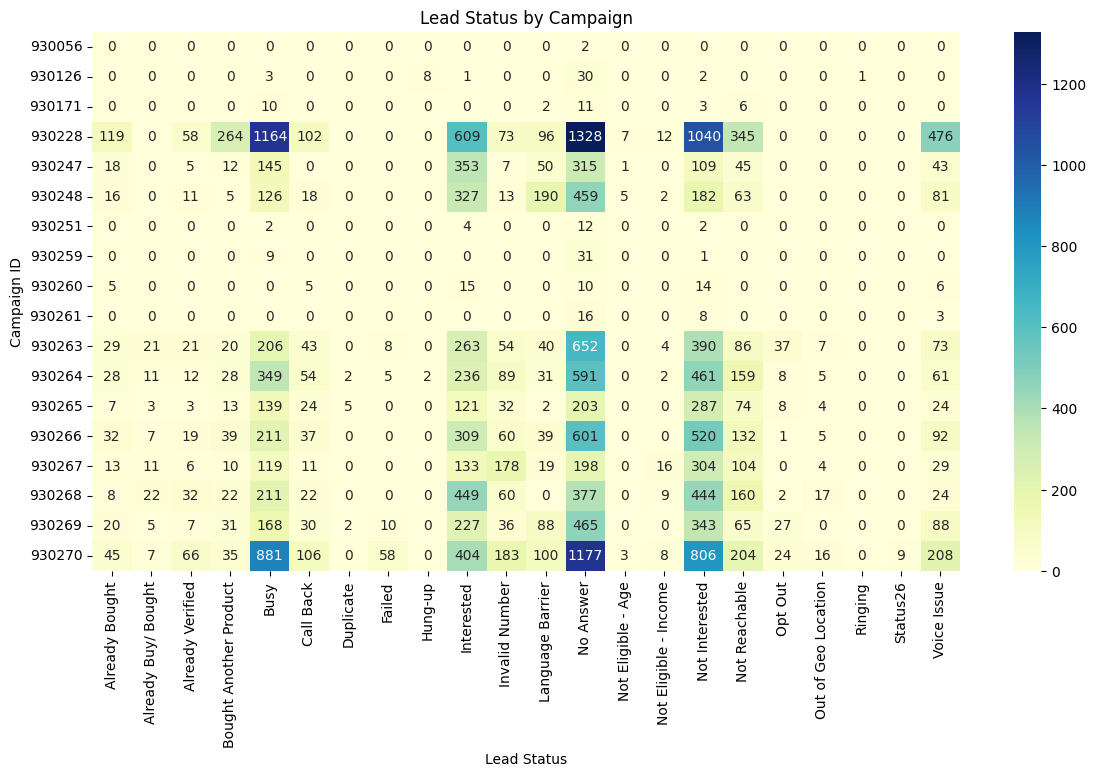

In [12]:
lead_status_by_campaign = pd.crosstab(data['Campaign ID'], data['Lead Status'])

plt.figure(figsize=(14, 7))
sns.heatmap(lead_status_by_campaign, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Lead Status by Campaign')
plt.xlabel('Lead Status')
plt.ylabel('Campaign ID')
plt.show()

Agent performance

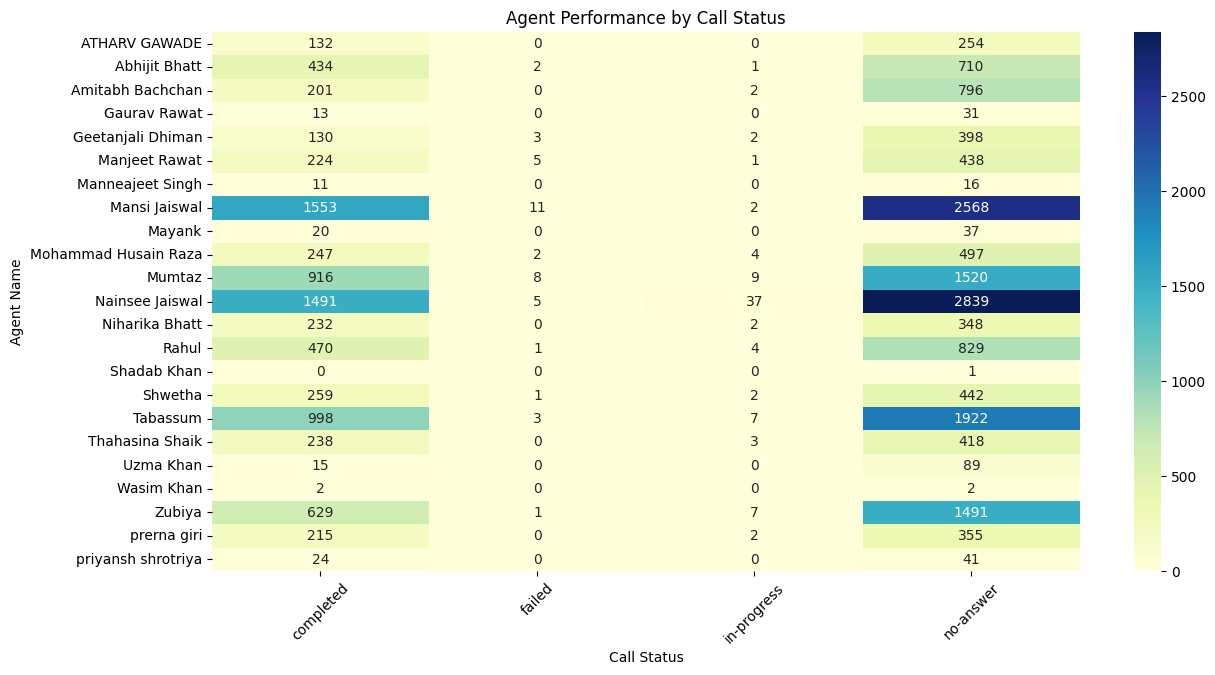

In [13]:
agent_performance = pd.crosstab(data['Agent Name'], data['Call Status'])

plt.figure(figsize=(14, 7))
sns.heatmap(agent_performance, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Agent Performance by Call Status')
plt.xlabel('Call Status')
plt.ylabel('Agent Name')
plt.xticks(rotation=45)
plt.show()

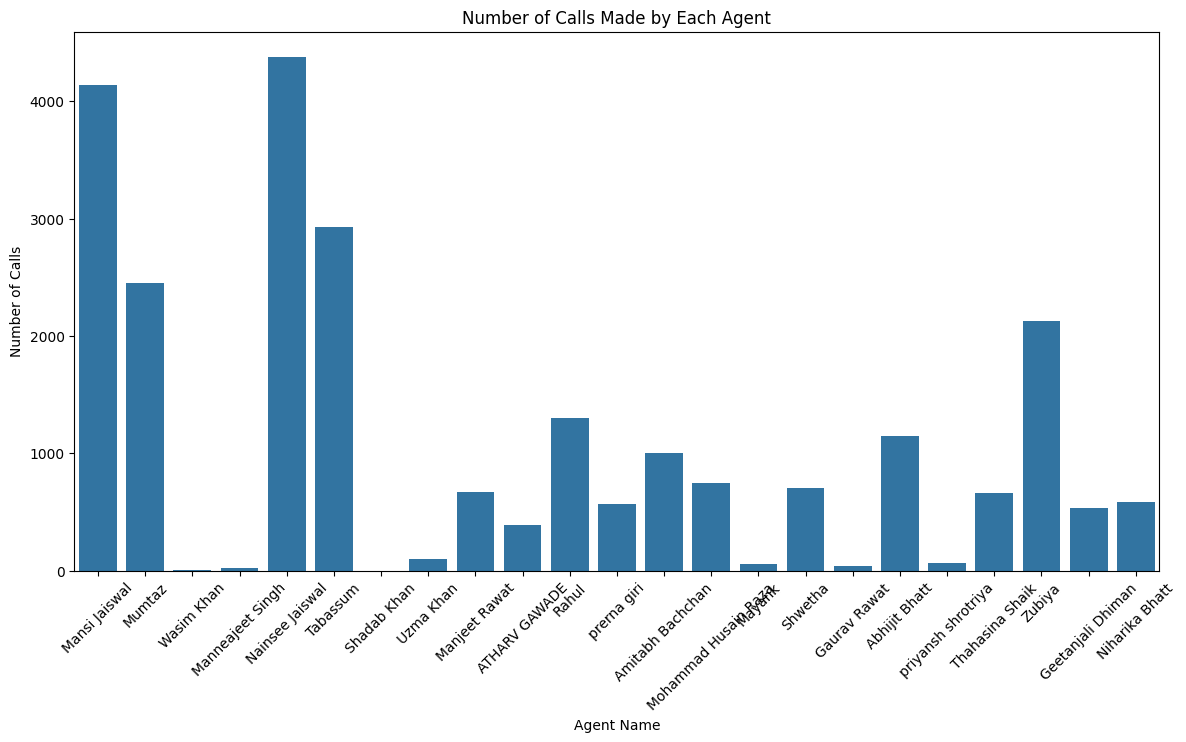

In [14]:
plt.figure(figsize=(14, 7))
sns.countplot(data=data, x='Agent Name')
plt.title('Number of Calls Made by Each Agent')
plt.xlabel('Agent Name')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)
plt.show()


Calculating the required metrics for each campaign.

In [15]:
campaign_report = data.groupby('Campaign ID').agg(
    total_calls=('Call Id', 'count'),
    unique_leads=('Lead Id', 'nunique'),
    calls_connected=('Call Status', lambda x: (x == 'Answered').sum()),
    unique_calls_connected=('Lead Id', lambda x: data[data['Call Status'] == 'Answered']['Lead Id'].nunique()),
    leads_converted=('Lead Status', lambda x: (x == 'Interested').sum()),
    qualified_leads=('Lead Status', lambda x: (x == 'Interested').sum()),  # Assuming 'Interested' means qualified
    leads_lost=('Lead Status', lambda x: (x == 'Not Interested').sum()),
    avg_agent_call_duration=('Agent Duration(seconds)', 'mean'),
    avg_customer_call_duration=('Customer Duration(seconds)', 'mean')
).reset_index()

print(campaign_report)


    Campaign ID  total_calls  unique_leads  calls_connected  \
0        930056            2             2                0   
1        930126           45            44                0   
2        930171           32            10                0   
3        930228         5693          2404                0   
4        930247         1103           255                0   
5        930248         1498           340                0   
6        930251           20             9                0   
7        930259           41            16                0   
8        930260           55            10                0   
9        930261           27            10                0   
10       930263         1954           685                0   
11       930264         2134           783                0   
12       930265          949           249                0   
13       930266         2104           613                0   
14       930267         1155           302             

<ipython-input-16-6a801dc00226>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=campaign_report, x='Campaign ID', y='total_calls', palette='viridis')


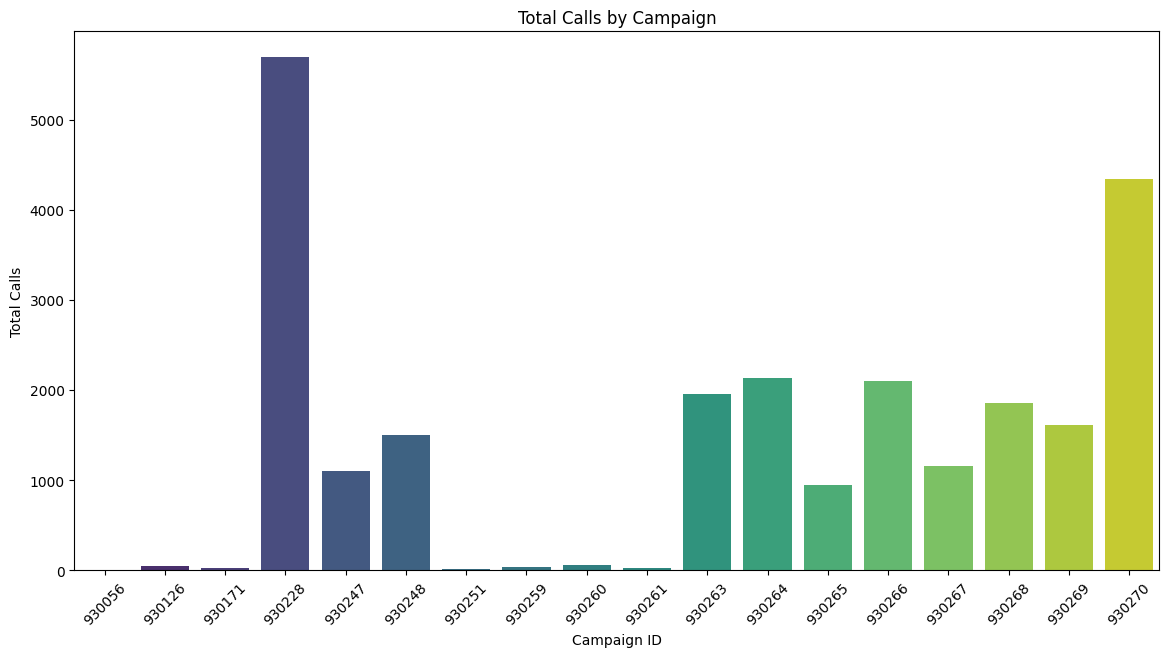

<ipython-input-16-6a801dc00226>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=campaign_report, x='Campaign ID', y='unique_leads', palette='viridis')


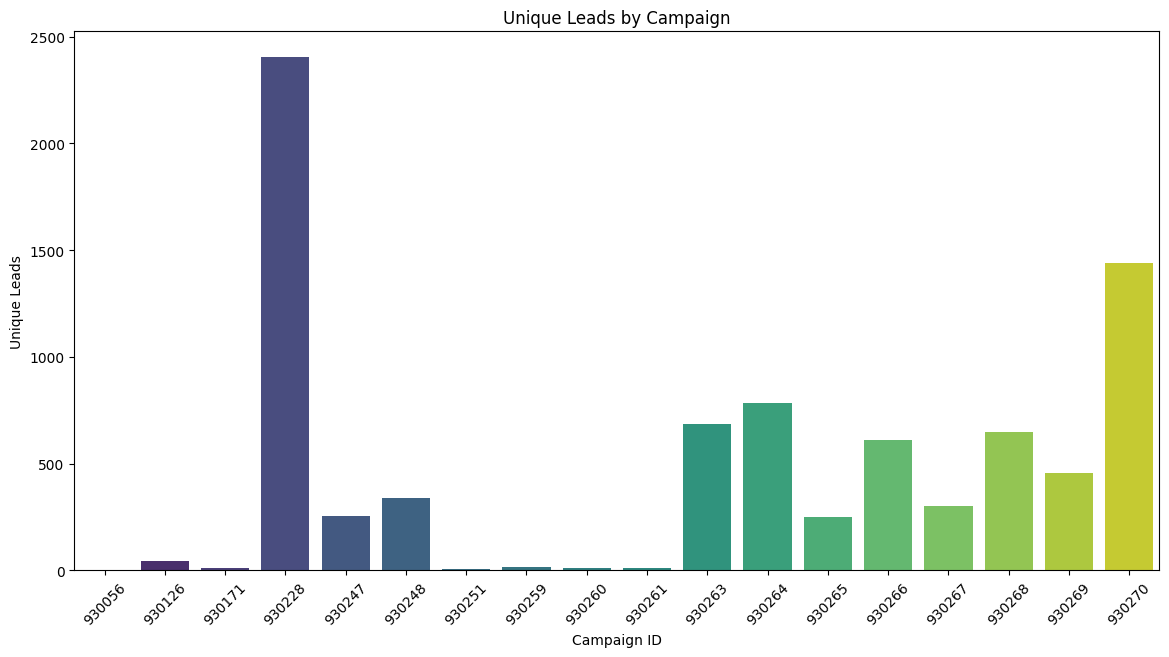

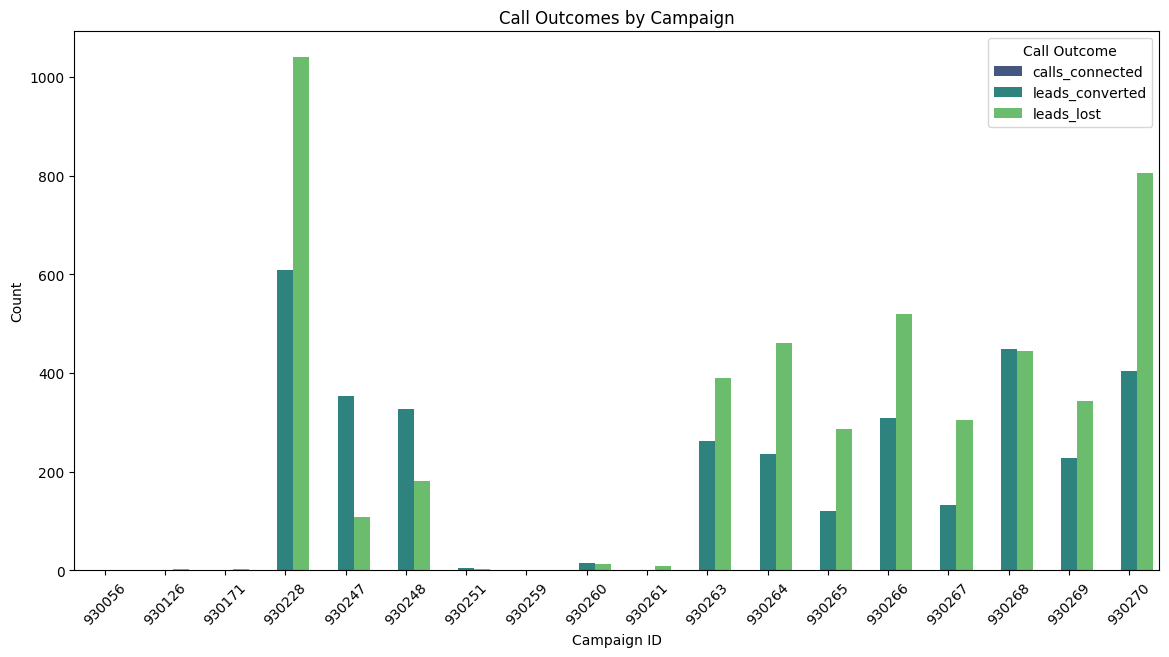

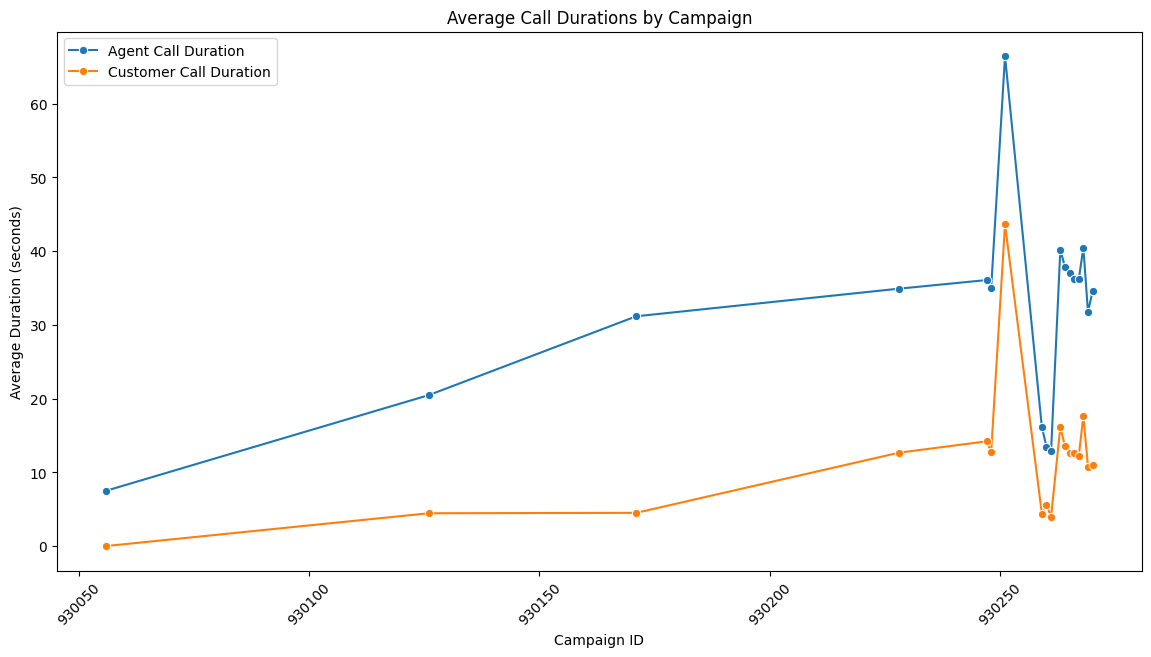

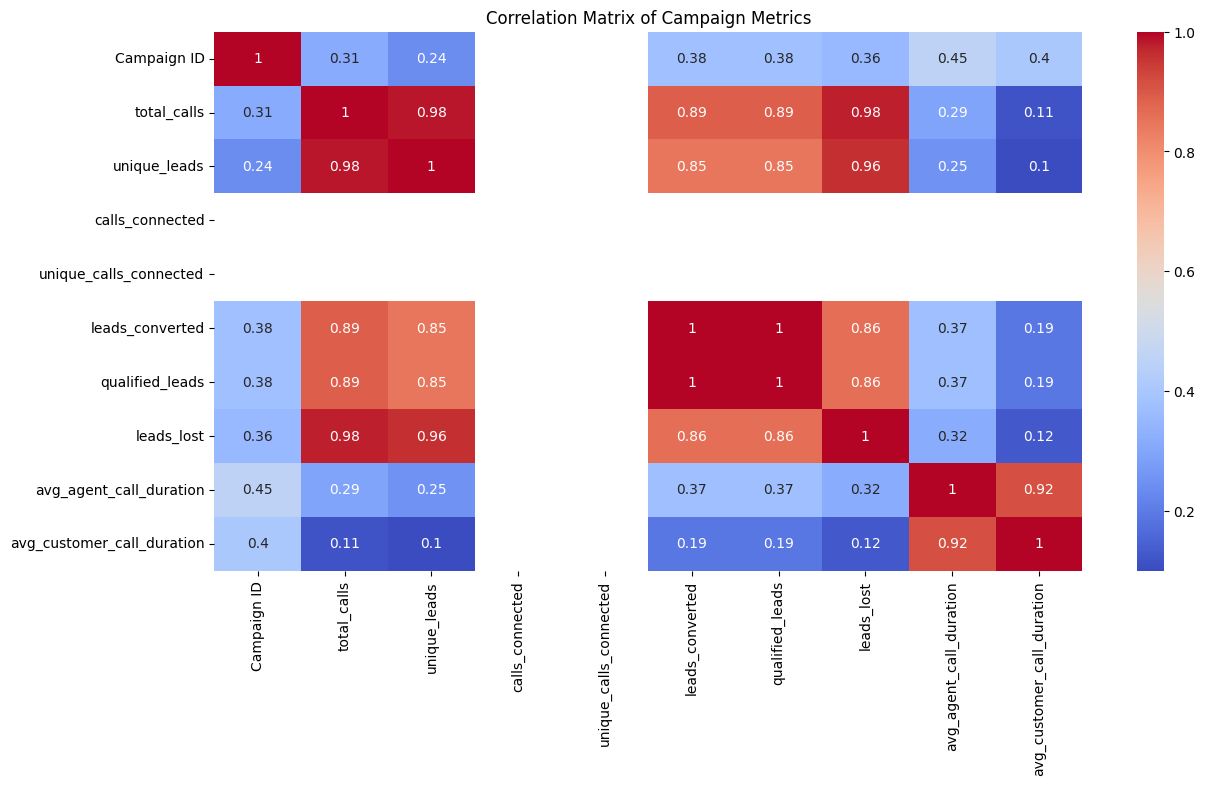

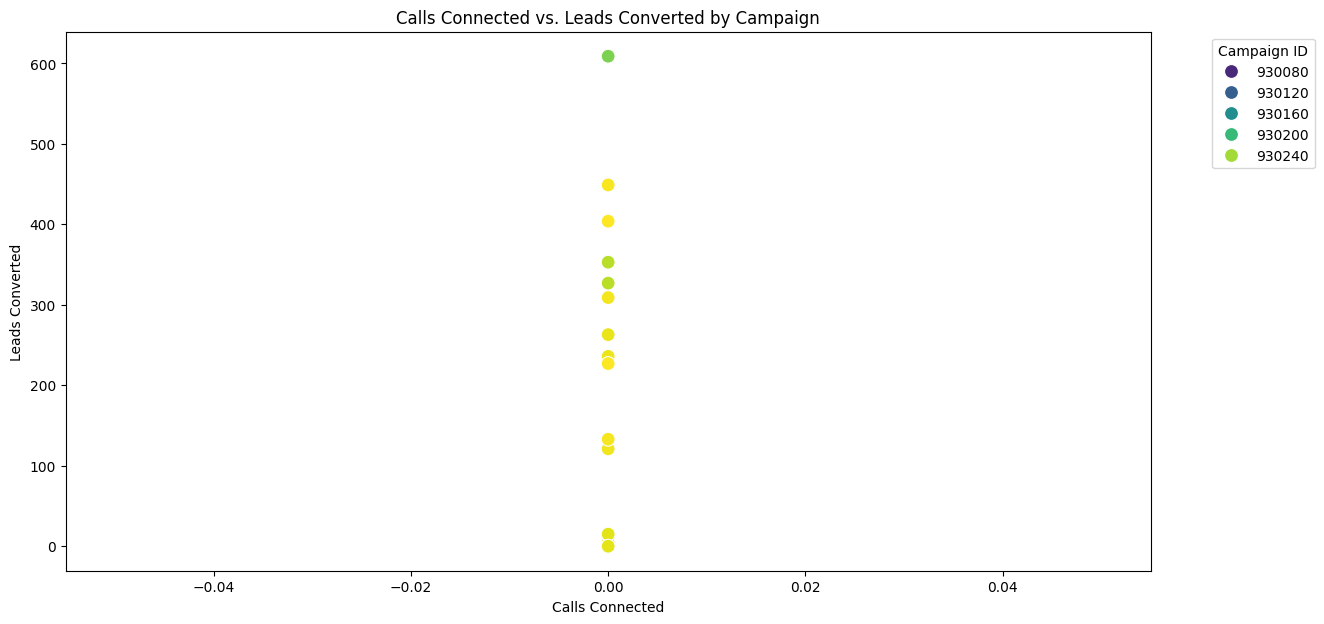

In [16]:
# Visualization 1: Total Calls by Campaign
plt.figure(figsize=(14, 7))
sns.barplot(data=campaign_report, x='Campaign ID', y='total_calls', palette='viridis')
plt.title('Total Calls by Campaign')
plt.xlabel('Campaign ID')
plt.ylabel('Total Calls')
plt.xticks(rotation=45)
plt.show()

# Visualization 2: Unique Leads by Campaign
plt.figure(figsize=(14, 7))
sns.barplot(data=campaign_report, x='Campaign ID', y='unique_leads', palette='viridis')
plt.title('Unique Leads by Campaign')
plt.xlabel('Campaign ID')
plt.ylabel('Unique Leads')
plt.xticks(rotation=45)
plt.show()

# Visualization 3: Stacked Bar Plot of Call Outcomes by Campaign
campaign_report_melted = campaign_report.melt(
    id_vars='Campaign ID',
    value_vars=['calls_connected', 'leads_converted', 'leads_lost'],
    var_name='Call Outcome',
    value_name='Count'
)

plt.figure(figsize=(14, 7))
sns.barplot(data=campaign_report_melted, x='Campaign ID', y='Count', hue='Call Outcome', palette='viridis')
plt.title('Call Outcomes by Campaign')
plt.xlabel('Campaign ID')
plt.ylabel('Count')
plt.legend(title='Call Outcome')
plt.xticks(rotation=45)
plt.show()

# Visualization 4: Average Call Durations by Campaign
plt.figure(figsize=(14, 7))
sns.lineplot(data=campaign_report, x='Campaign ID', y='avg_agent_call_duration', marker='o', label='Agent Call Duration')
sns.lineplot(data=campaign_report, x='Campaign ID', y='avg_customer_call_duration', marker='o', label='Customer Call Duration')
plt.title('Average Call Durations by Campaign')
plt.xlabel('Campaign ID')
plt.ylabel('Average Duration (seconds)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Visualization 5: Correlation Matrix of Campaign Metrics
plt.figure(figsize=(14, 7))
sns.heatmap(campaign_report.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Campaign Metrics')
plt.show()

# Visualization 6: Calls Connected vs. Leads Converted by Campaign
plt.figure(figsize=(14, 7))
sns.scatterplot(data=campaign_report, x='calls_connected', y='leads_converted', hue='Campaign ID', palette='viridis', s=100)
plt.title('Calls Connected vs. Leads Converted by Campaign')
plt.xlabel('Calls Connected')
plt.ylabel('Leads Converted')
plt.legend(title='Campaign ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [17]:
# Create pivot table
pivot_table = pd.pivot_table(campaign_report,
                             index='Campaign ID',
                             values=['total_calls', 'unique_leads', 'calls_connected',
                                     'leads_converted', 'leads_lost', 'avg_agent_call_duration',
                                     'avg_customer_call_duration'],
                             aggfunc={'total_calls': 'sum',
                                      'unique_leads': 'sum',
                                      'calls_connected': 'sum',
                                      'leads_converted': 'sum',
                                      'leads_lost': 'sum',
                                      'avg_agent_call_duration': 'mean',
                                      'avg_customer_call_duration': 'mean'})

# Print pivot table
print(pivot_table)


             avg_agent_call_duration  avg_customer_call_duration  \
Campaign ID                                                        
930056                      7.500000                    0.000000   
930126                     20.466667                    4.444444   
930171                     31.156250                    4.500000   
930228                     34.900228                   12.657825   
930247                     36.067090                   14.197643   
930248                     35.020027                   12.791055   
930251                     66.450000                   43.650000   
930259                     16.097561                    4.365854   
930260                     13.472727                    5.545455   
930261                     12.888889                    4.000000   
930263                     40.205732                   16.142272   
930264                     37.858482                   13.575914   
930265                     37.052687            

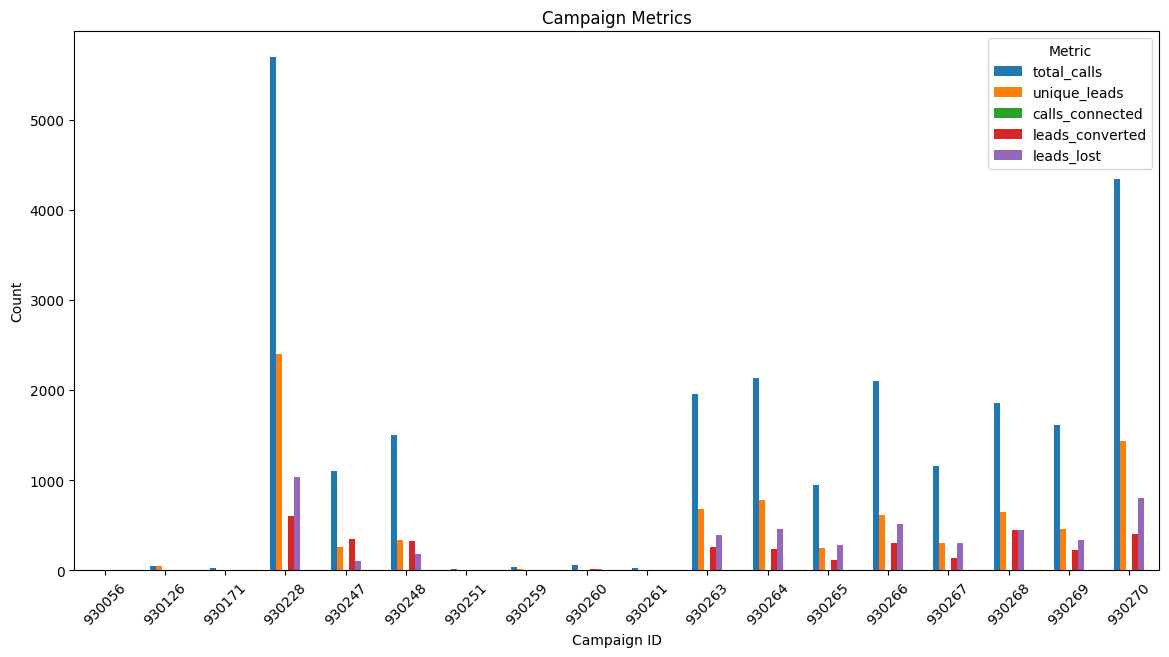

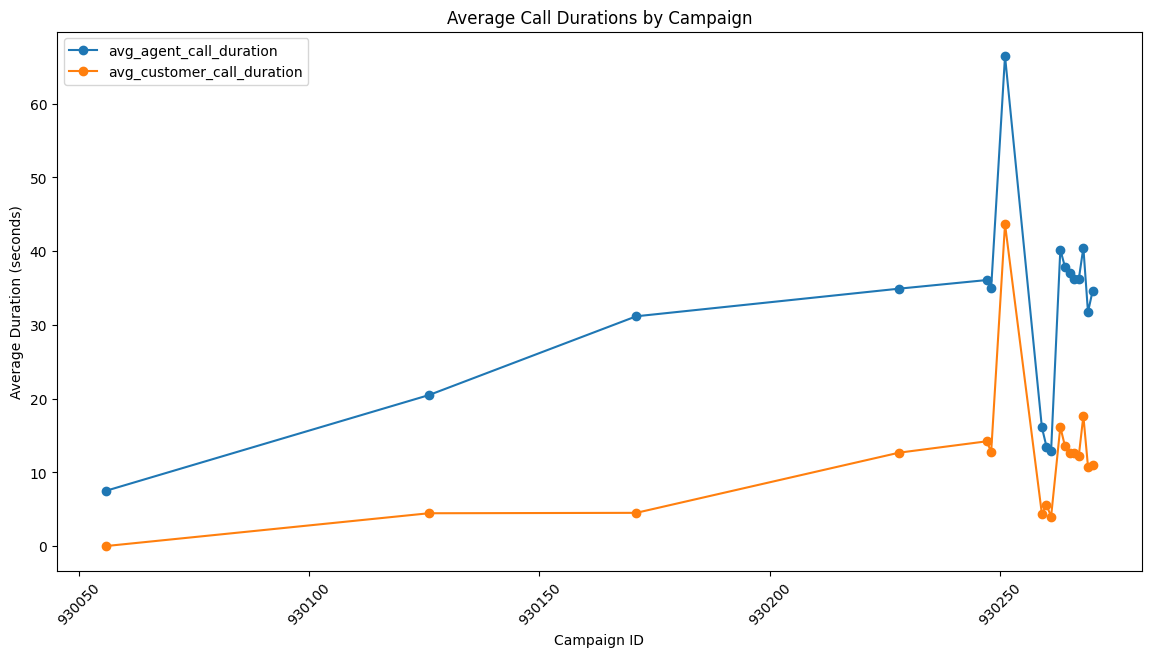

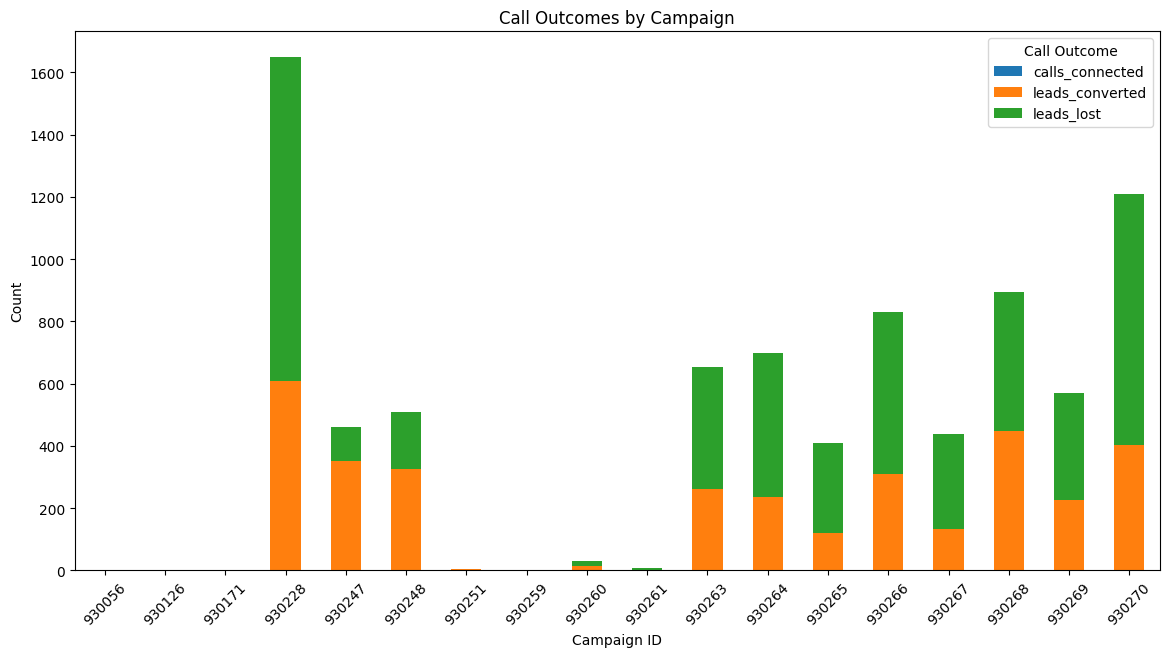

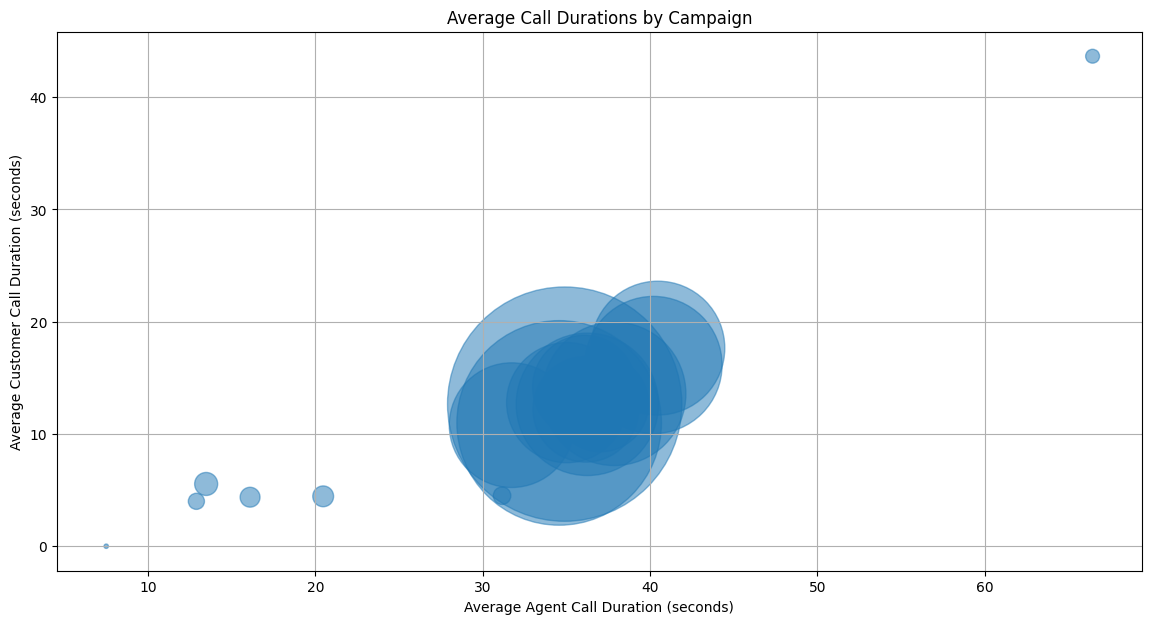

In [18]:
# Visualization 1: Total Calls, Unique Leads, Calls Connected, Leads Converted, and Leads Lost by Campaign
pivot_table[['total_calls', 'unique_leads', 'calls_connected', 'leads_converted', 'leads_lost']].plot(kind='bar', figsize=(14, 7))
plt.title('Campaign Metrics')
plt.xlabel('Campaign ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.show()

# Visualization 2: Average Agent Call Duration and Average Customer Call Duration by Campaign
pivot_table[['avg_agent_call_duration', 'avg_customer_call_duration']].plot(kind='line', marker='o', figsize=(14, 7))
plt.title('Average Call Durations by Campaign')
plt.xlabel('Campaign ID')
plt.ylabel('Average Duration (seconds)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Visualization 3: Stacked Bar Plot: Comparison of Calls Connected, Leads Converted, and Leads Lost by Campaign
pivot_table[['calls_connected', 'leads_converted', 'leads_lost']].plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Call Outcomes by Campaign')
plt.xlabel('Campaign ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Call Outcome')
plt.show()

# Visualization 4: Scatter Plot: Average Agent Call Duration vs. Average Customer Call Duration by Campaign
plt.figure(figsize=(14, 7))
plt.scatter(pivot_table['avg_agent_call_duration'], pivot_table['avg_customer_call_duration'], s=pivot_table['total_calls']*5, alpha=0.5)
plt.title('Average Call Durations by Campaign')
plt.xlabel('Average Agent Call Duration (seconds)')
plt.ylabel('Average Customer Call Duration (seconds)')
plt.grid(True)


Lead Disposition Report

               Lead Status  Count
0                No Answer   6478
1           Not Interested   4916
2                     Busy   3743
3               Interested   3451
4            Not Reachable   1443
5              Voice Issue   1208
6           Invalid Number    785
7         Language Barrier    657
8   Bought Another Product    479
9                Call Back    452
10          Already Bought    340
11        Already Verified    240
12                 Opt Out    107
13     Already Buy/ Bought     87
14                  Failed     81
15     Out of Geo Location     58
16   Not Eligible - Income     53
17      Not Eligible - Age     16
18                 Hung-up     10
19               Duplicate      9
20                Status26      9
21                 Ringing      1


<ipython-input-19-04d7e220ee7b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lead Status', y='Count', data=disposition_report, palette='viridis')


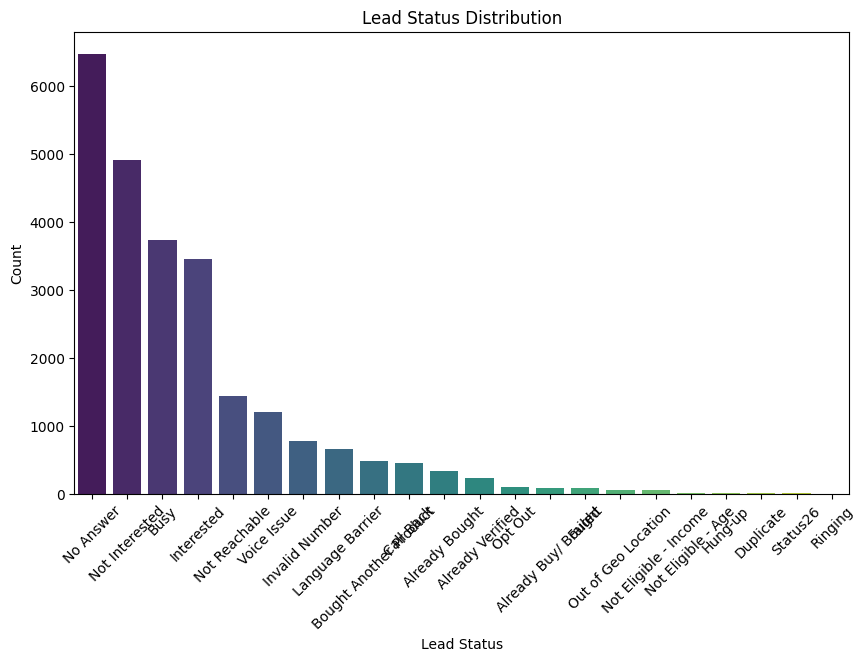

In [19]:
disposition_report = data['Lead Status'].value_counts().reset_index()
disposition_report.columns = ['Lead Status', 'Count']

print(disposition_report)
# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Lead Status', y='Count', data=disposition_report, palette='viridis')
plt.title('Lead Status Distribution')
plt.xlabel('Lead Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Agent Performance Report


    Agent Id  number_of_calls  calls_connected  leads_converted  \
0          1                4                0                0   
1        779               27                0                4   
2       1656                1                0                0   
3       2707              104                0               15   
4       2714             2453                0              374   
5       2728             4134                0              699   
6       2771             4372                0              685   
7       2772             2930                0              315   
8       2778              659                0               99   
9       2780              999                0              117   
10      2783             1147                0              142   
11      2784               57                0                5   
12      2787              572                0               69   
13      2790              750                0               9

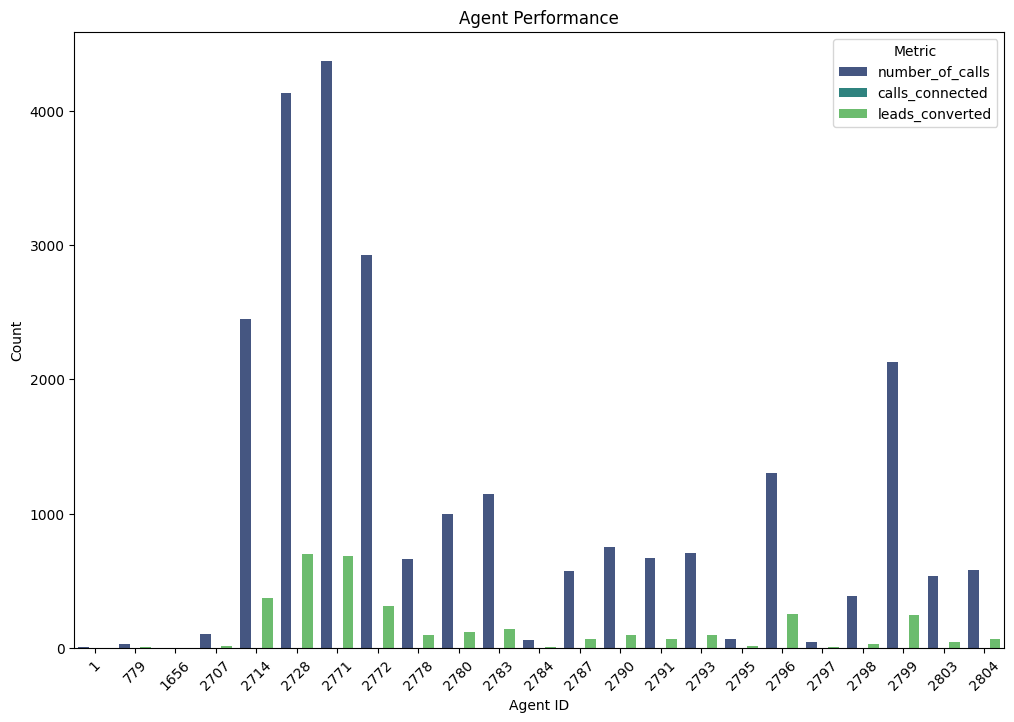

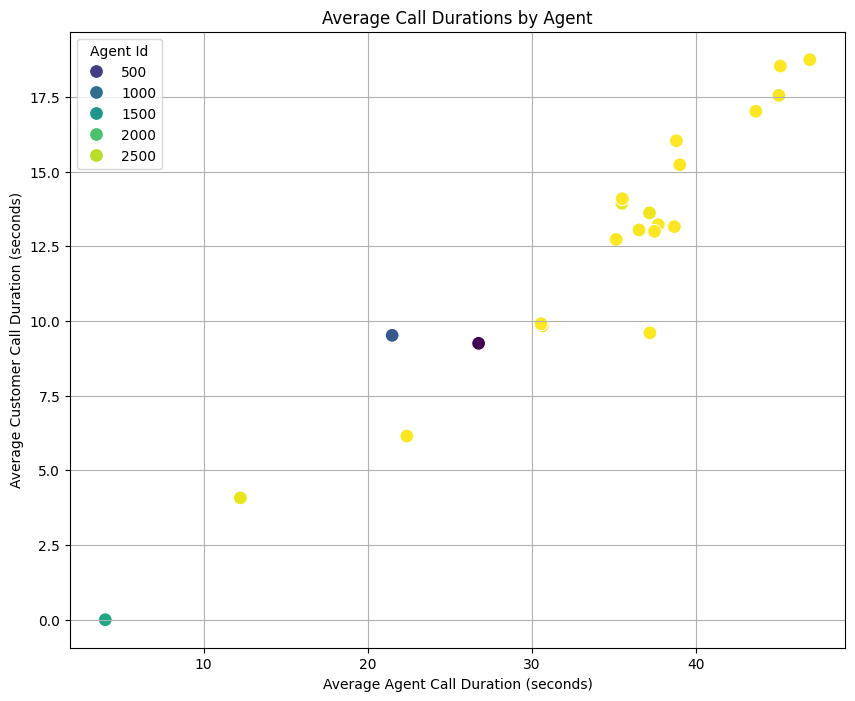

In [20]:
agent_report = data.groupby('Agent Id').agg(
    number_of_calls=('Call Id', 'count'),
    calls_connected=('Call Status', lambda x: (x == 'Answered').sum()),
    leads_converted=('Lead Status', lambda x: (x == 'Interested').sum()),
    avg_agent_call_duration=('Agent Duration(seconds)', 'mean'),
    avg_customer_call_duration=('Customer Duration(seconds)', 'mean')
).reset_index()

print(agent_report)

# Bar plot for number of calls, calls connected, and leads converted by agent
plt.figure(figsize=(12, 8))
sns.barplot(x='Agent Id', y='value', hue='variable', data=pd.melt(agent_report, id_vars=['Agent Id'], value_vars=['number_of_calls', 'calls_connected', 'leads_converted']), palette='viridis')
plt.title('Agent Performance')
plt.xlabel('Agent ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.show()

# Scatter plot for average agent call duration vs. average customer call duration by agent
plt.figure(figsize=(10, 8))
sns.scatterplot(data=agent_report, x='avg_agent_call_duration', y='avg_customer_call_duration', hue='Agent Id', palette='viridis', s=100)
plt.title('Average Call Durations by Agent')
plt.xlabel('Average Agent Call Duration (seconds)')
plt.ylabel('Average Customer Call Duration (seconds)')
plt.grid(True)
plt.show()

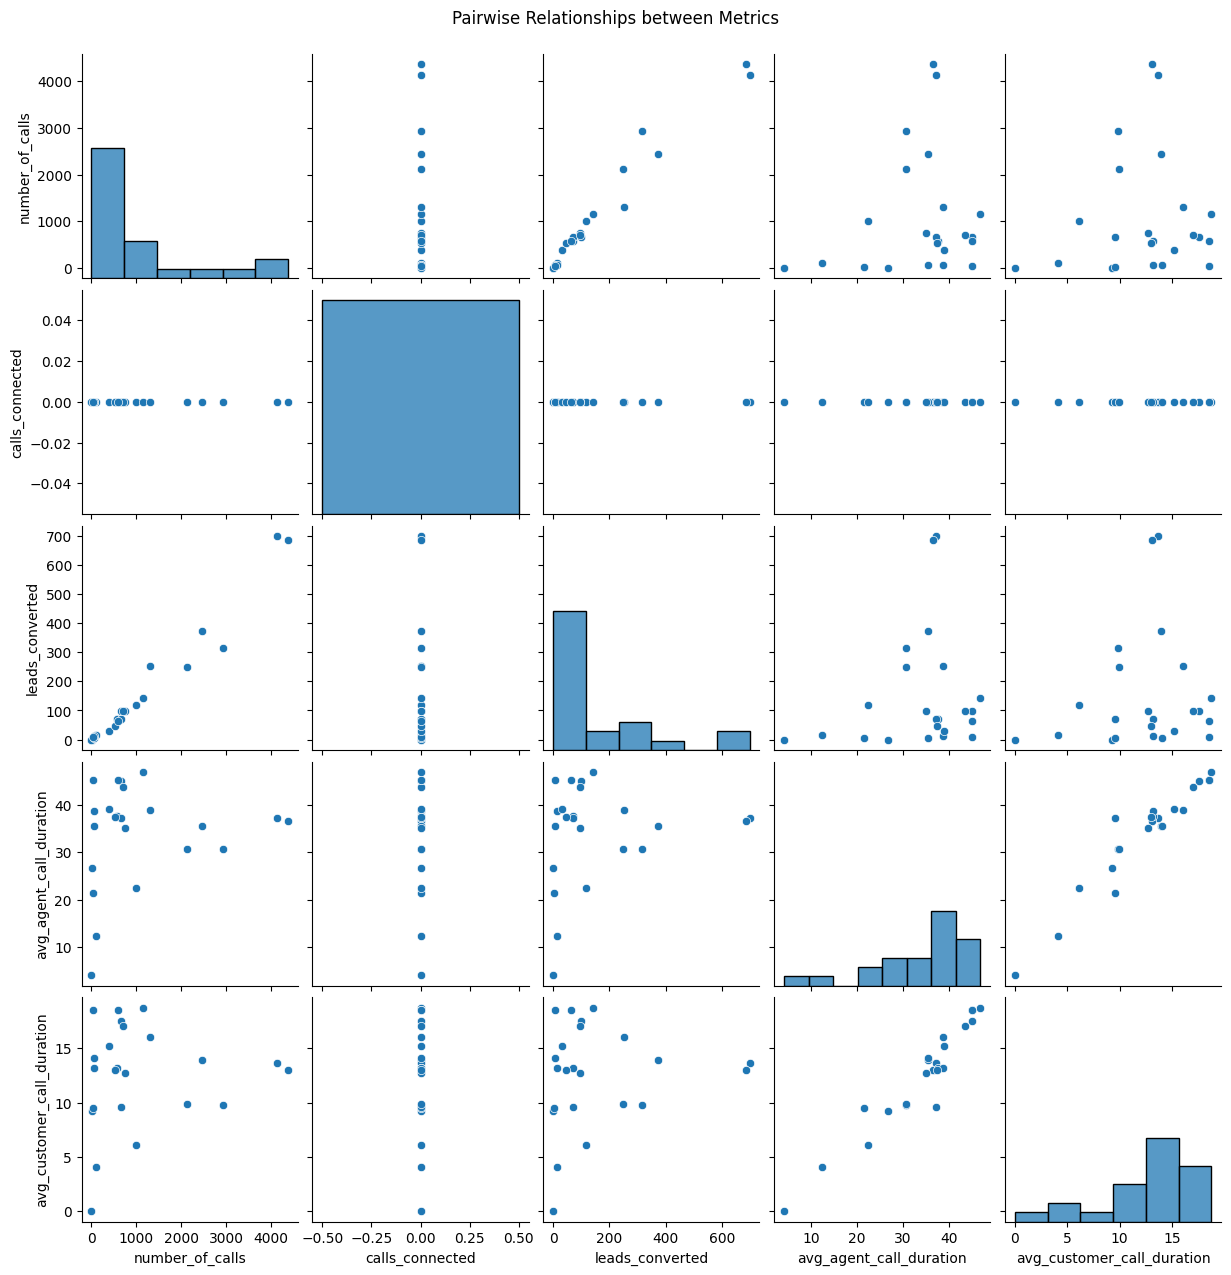

In [21]:
sns.pairplot(agent_report[['number_of_calls', 'calls_connected', 'leads_converted', 'avg_agent_call_duration', 'avg_customer_call_duration']])
plt.suptitle('Pairwise Relationships between Metrics', y=1.02)
plt.show()

Average Call Durations Per Agent

              Agent Name  Average Agent Duration(seconds)
0          ATHARV GAWADE                        39.007772
1          Abhijit Bhatt                        46.931997
2       Amitabh Bachchan                        22.380380
3           Gaurav Rawat                        45.181818
4      Geetanjali Dhiman                        37.469043
5          Manjeet Rawat                        37.188623
6       Manneajeet Singh                        21.481481
7          Mansi Jaiswal                        37.163280
8                 Mayank                        35.508772
9   Mohammad Husain Raza                        35.133333
10                Mumtaz                        35.485120
11       Nainsee Jaiswal                        36.529735
12        Niharika Bhatt                        45.135739
13                 Rahul                        38.801380
14           Shadab Khan                         4.000000
15               Shwetha                        43.643466
16            

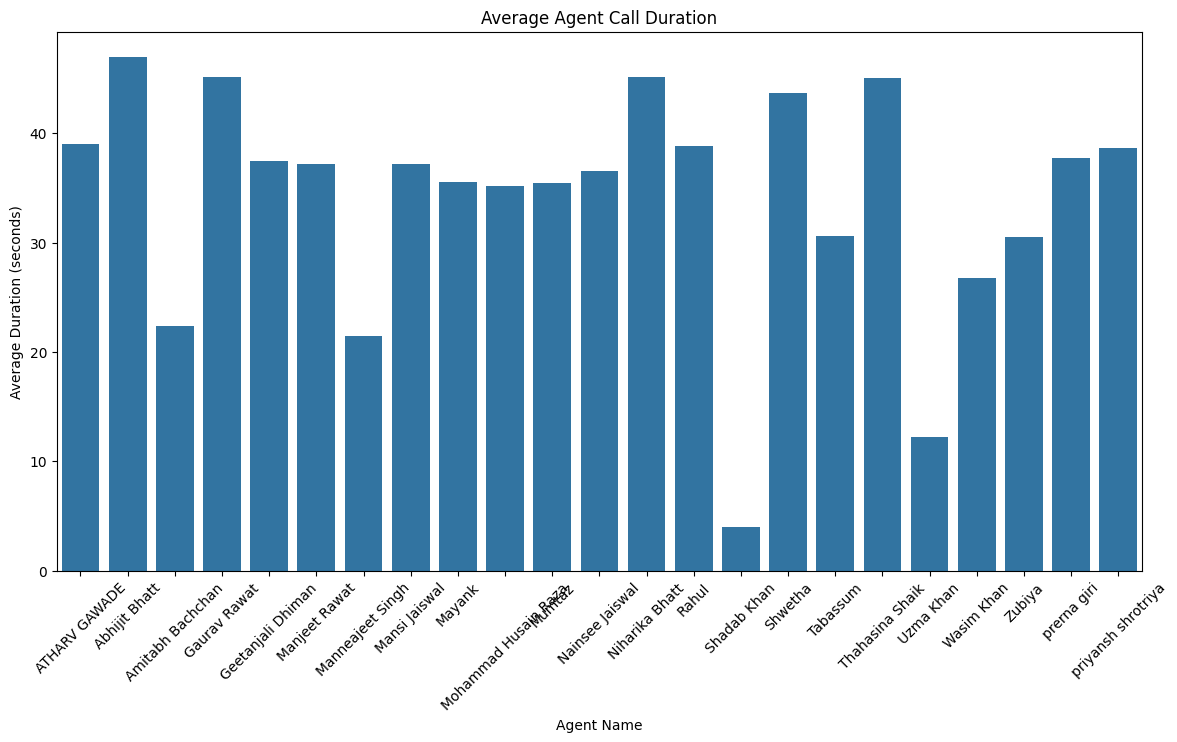

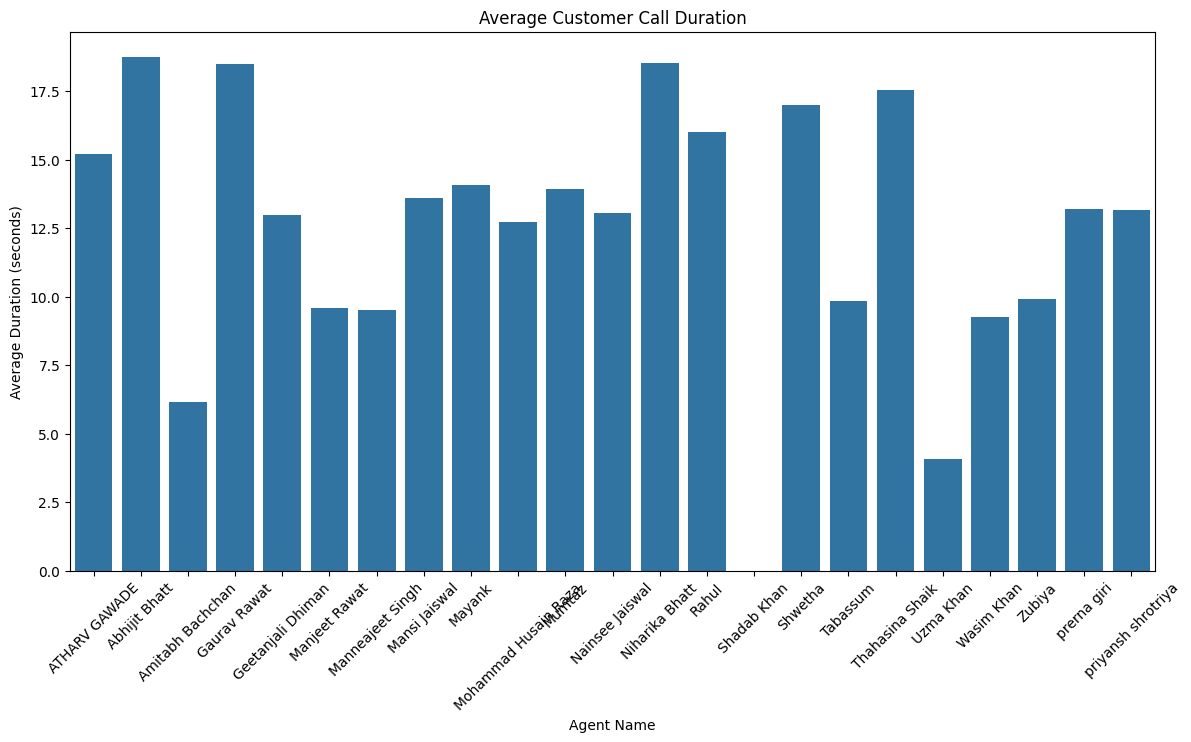

In [24]:
avg_agent_call_duration = data.groupby('Agent Name')['Agent Duration(seconds)'].mean().reset_index()
avg_agent_call_duration.columns = ['Agent Name', 'Average Agent Duration(seconds)']
print(avg_agent_call_duration)

avg_customer_call_duration = data.groupby('Agent Name')['Customer Duration(seconds)'].mean().reset_index()
avg_customer_call_duration.columns = ['Agent Name', 'Average Customer Duration(seconds)']
print(avg_customer_call_duration)

plt.figure(figsize=(14, 7))
sns.barplot(data=avg_agent_call_duration, x='Agent Name', y='Average Agent Duration(seconds)')
plt.title('Average Agent Call Duration')
plt.xlabel('Agent Name')
plt.ylabel('Average Duration (seconds)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(data=avg_customer_call_duration, x='Agent Name', y='Average Customer Duration(seconds)')
plt.title('Average Customer Call Duration')
plt.xlabel('Agent Name')
plt.ylabel('Average Duration (seconds)')
plt.xticks(rotation=45)
plt.show()


Correlation Analysis


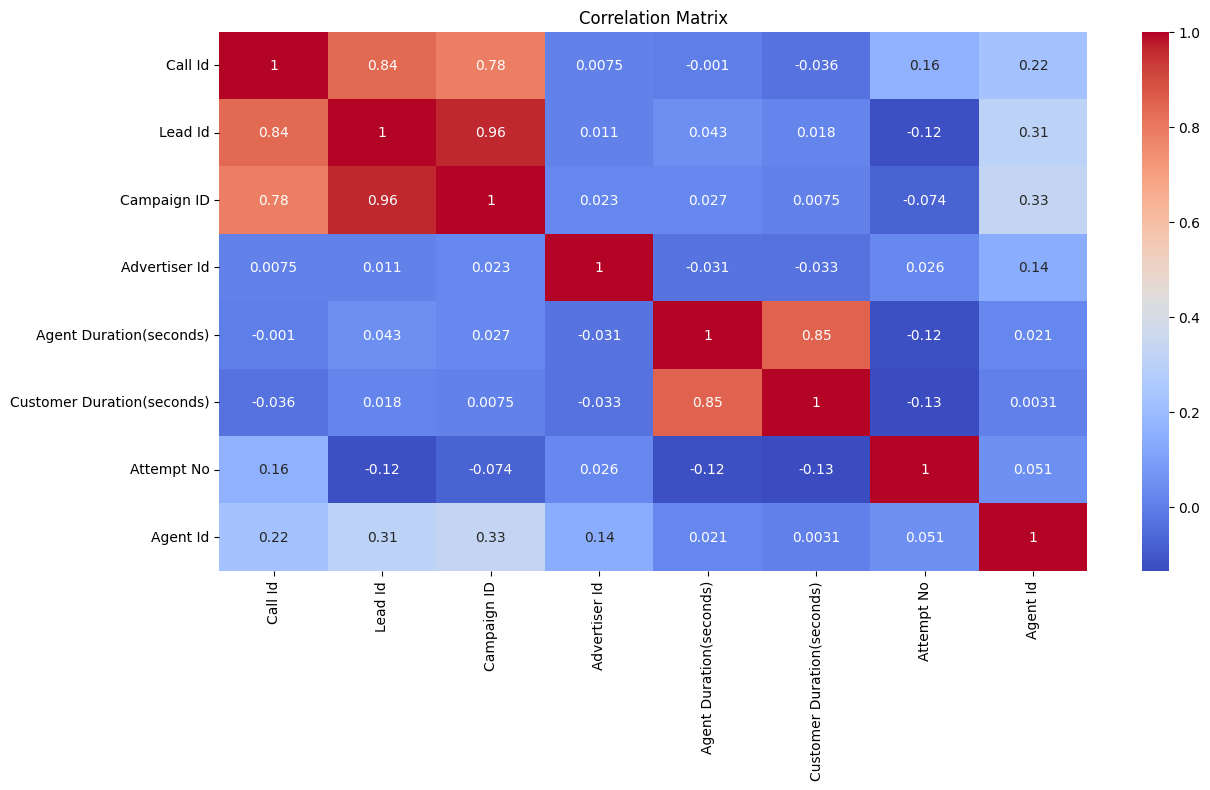

In [25]:
# Exclude non-numeric columns
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Relationship Between Call and Lead Statuses

Lead Status  Call Status  Already Bought  Already Buy/ Bought  \
0              completed        0.024722             0.006151   
1                 failed        0.000000             0.000000   
2            in-progress        0.000000             0.000000   
3              no-answer        0.008166             0.002182   

Lead Status  Already Verified  Bought Another Product      Busy  Call Back  \
0                    0.019281                0.037497  0.050863   0.028980   
1                    0.000000                0.023810  0.119048   0.000000   
2                    0.000000                0.000000  0.329412   0.094118   
3                    0.004800                0.010036  0.204463   0.012405   

Lead Status  Duplicate    Failed   Hung-up  ...  No Answer  \
0             0.000591  0.002129  0.001183  ...   0.072628   
1             0.000000  0.023810  0.000000  ...   0.476190   
2             0.000000  0.023529  0.000000  ...   0.223529   
3             0.000249  0.003740  0

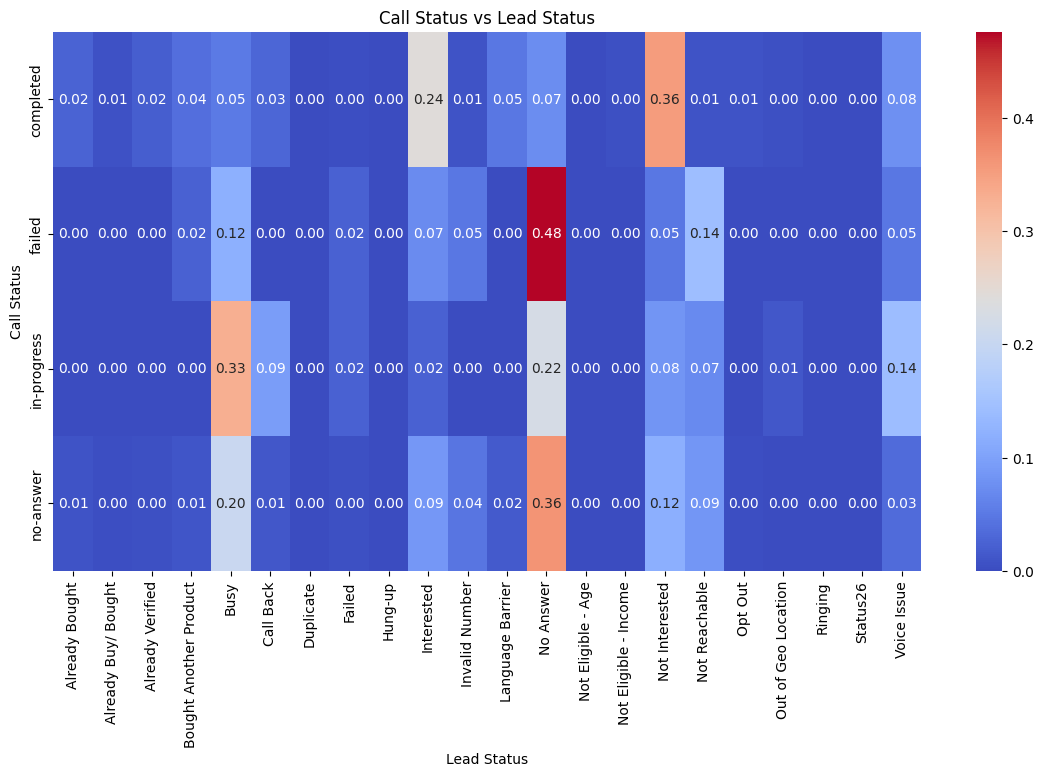

In [26]:
call_lead_status = pd.crosstab(data['Call Status'], data['Lead Status'], normalize='index').reset_index()
print(call_lead_status)

plt.figure(figsize=(14, 7))
sns.heatmap(pd.crosstab(data['Call Status'], data['Lead Status'], normalize='index'), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Call Status vs Lead Status')
plt.xlabel('Lead Status')
plt.ylabel('Call Status')
plt.show()


**Forecasting**

1.   Call Volume Forecast




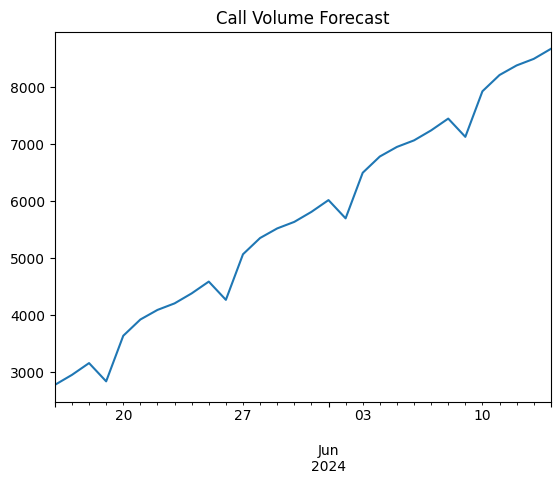

In [27]:
# Aggregate daily call volume
daily_calls = data.resample('D', on='Created At').size()

# Fit the model
model = ExponentialSmoothing(daily_calls, trend='add', seasonal='add', seasonal_periods=7).fit()

# Forecast for the next 30 days
forecast = model.forecast(30)
forecast.plot(title='Call Volume Forecast')
plt.show()




2.   Lead Conversion Forecast



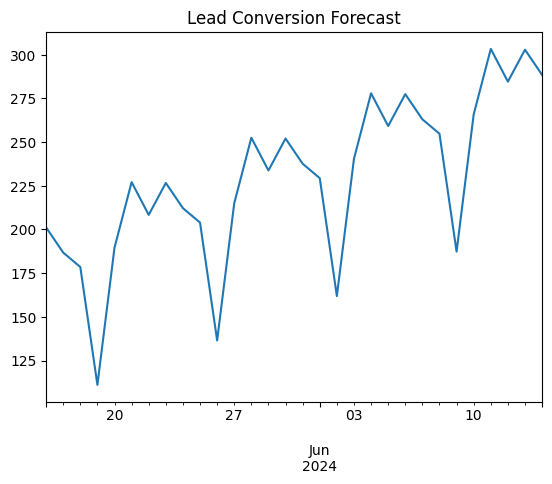

In [28]:
daily_conversions = data[data['Lead Status'] == 'Interested'].resample('D', on='Created At').size()

# Fit the model
model = ExponentialSmoothing(daily_conversions, trend='add', seasonal='add', seasonal_periods=7).fit()

# Forecast for the next 30 days
forecast = model.forecast(30)
forecast.plot(title='Lead Conversion Forecast')
plt.show()


3. agent efficiency forecasting

In [29]:
!pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 71.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running set

In [30]:
from fbprophet import Prophet

# Prepare the data
agent_metrics.reset_index(inplace=True)
agent_metrics.rename(columns={'Date': 'ds', 'Avg Agent Duration (seconds)': 'y'}, inplace=True)

# Forecasting for 'Avg Agent Duration (seconds)'
model = Prophet()
model.fit(agent_metrics[['ds', 'y']])
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plotting the forecast
plt.figure(figsize=(12, 6))
model.plot(forecast, xlabel='Date', ylabel='Avg Agent Duration (seconds)', ax=plt.gca())
plt.title('Prophet Forecast: Avg Agent Duration (seconds)')
plt.show()

# Forecasting for 'Avg Customer Duration (seconds)'
agent_metrics.rename(columns={'Avg Customer Duration (seconds)': 'y'}, inplace=True)

model = Prophet()
model.fit(agent_metrics[['ds', 'y']])
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plotting the forecast
plt.figure(figsize=(12, 6))
model.plot(forecast, xlabel='Date', ylabel='Avg Customer Duration (seconds)', ax=plt.gca())
plt.title('Prophet Forecast: Avg Customer Duration (seconds)')
plt.show()

# Forecasting for 'Number of Calls'
agent_metrics.rename(columns={'Number of Calls': 'y'}, inplace=True)

model = Prophet()
model.fit(agent_metrics[['ds', 'y']])
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plotting the forecast
plt.figure(figsize=(12, 6))
model.plot(forecast, xlabel='Date', ylabel='Number of Calls', ax=plt.gca())
plt.title('Prophet Forecast: Number of Calls')
plt.show()


ModuleNotFoundError: No module named 'fbprophet'

4. resource allocation forecast

In [31]:

# Combine call volume forecast and agent metrics
resource_allocation_data = pd.merge(call_volume_forecast, agent_metrics, on='Date', how='left')

# Calculate the expected call volume per hour
resource_allocation_data['Expected_Calls_Per_Hour'] = resource_allocation_data['Call_Volume'] / 24

# Assuming your performance level metric is calls per hour
# Calculate the number of agents required to handle the expected call volume
resource_allocation_data['Agents_Required'] = resource_allocation_data['Expected_Calls_Per_Hour'] / resource_allocation_data['Performance_Metric']

# Plot the resource allocation forecast
plt.figure(figsize=(14, 7))
plt.plot(resource_allocation_data['Date'], resource_allocation_data['Agents_Required'], marker='o')
plt.title('Resource Allocation Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Agents Required')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


NameError: name 'call_volume_forecast' is not defined